In [1]:
# import required libraries

import os
import sys
import configparser

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.transforms import RandomAffine

In [2]:
# set the device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device)

Device is: cuda


In [3]:
# set the hyperparameters

config = configparser.ConfigParser()

config['CAE'] = {'rand_seed': 765, 'ks': 3, 'nf0': 15, 'nf1': 45, 'nf2': 128, 'nf3': 196, 'nf4': 128, 'nf5': 128, 'nf6': 128,
                 'nfc': 14}

config['IM'] = {'lambda_affine': 0.03, 'lambda_marginal_entropy': 0.1, 'lambda_conditional_entropy': 0.03,
                'learning_rate': 0.003}

config.write(sys.stdout)

[CAE]
rand_seed = 765
ks = 3
nf0 = 15
nf1 = 45
nf2 = 128
nf3 = 196
nf4 = 128
nf5 = 128
nf6 = 128
nfc = 14

[IM]
lambda_affine = 0.03
lambda_marginal_entropy = 0.1
lambda_conditional_entropy = 0.03
learning_rate = 0.003



In [4]:
rand_seed = int(config['CAE']['rand_seed'])
ks        = int(config['CAE']['ks'])
nf0       = int(config['CAE']['nf0'])
nf1       = int(config['CAE']['nf1'])
nf2       = int(config['CAE']['nf2'])
nf3       = int(config['CAE']['nf3'])
nf4       = int(config['CAE']['nf4'])
nf5       = int(config['CAE']['nf5'])
nf6       = int(config['CAE']['nf6'])
nfc       = int(config['CAE']['nfc'])

In [5]:
lambda_affine              = float(config['IM']['lambda_affine'])
lambda_marginal_entropy    = float(config['IM']['lambda_marginal_entropy'])
lambda_conditional_entropy = float(config['IM']['lambda_conditional_entropy'])
learning_rate              = float(config['IM']['learning_rate'])

In [6]:
# set random seed

print('random seed:', rand_seed)

torch.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)
np.random.seed(rand_seed)

random seed: 765


In [7]:
# load the dataset

data_src = np.load('/project/dsc-is/mahfujul-r/M/slice128_Block2_20K.npy') # location of the dataset

In [8]:
# custom functions to extract batches of samples

def get_batch_index_tr(tr, batch_size=None, shuffle=True):
    if (shuffle):
        np.random.shuffle(tr)
    if (batch_size is not None):
        n_batch = len(tr) // batch_size
    batch_list = np.array_split(tr, n_batch)
    return batch_list

def get_batch_index_ae(ae, batch_size=None, shuffle=True):
    tr = np.arange(ae)
    batch_list = get_batch_index_tr(tr, batch_size=batch_size, shuffle=shuffle)
    return batch_list

In [9]:
ix, iy = 64, 64 # 128x128 patches are getting rescaled

#affine transformation
add_random_affine = RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), fill=(161, 138, 172)) 

def generate_batch(iii, src, device, random_affine=False):
    if (random_affine):
        tmp = np.empty((len(iii), ix, iy, nf0))
        for aa, ii in enumerate(iii):
            img_tmp0 = Image.fromarray(src[ii, 0])
            img_tmp0 = add_random_affine(img_tmp0).resize((ix, iy)) # HE
            img_tmp4 = Image.fromarray(src[ii, 4])
            img_tmp4 = add_random_affine(img_tmp4).resize((ix, iy)) # CD31
            img_tmp5 = Image.fromarray(src[ii, 5])
            img_tmp5 = add_random_affine(img_tmp5).resize((ix, iy)) # CK19
            img_tmp6 = Image.fromarray(src[ii, 6])
            img_tmp6 = add_random_affine(img_tmp6).resize((ix, iy)) # Ki67
            img_tmp7 = Image.fromarray(src[ii, 7])
            img_tmp7 = add_random_affine(img_tmp7).resize((ix, iy)) # MT
            tmp[aa] = np.concatenate((img_tmp0, img_tmp4, img_tmp5, img_tmp6, img_tmp7), axis=2)
        xxx = torch.tensor(tmp/255.0, dtype=torch.float32).permute(0, 3, 2, 1)
    
    else:
        tmp = np.empty((len(iii), ix, iy, nf0))
        for aa, ii in enumerate(iii):
            img_tmp0 = Image.fromarray(src[ii, 0]).resize((ix, iy)) # HE
            img_tmp4 = Image.fromarray(src[ii, 4]).resize((ix, iy)) # CD31
            img_tmp5 = Image.fromarray(src[ii, 5]).resize((ix, iy)) # CK19
            img_tmp6 = Image.fromarray(src[ii, 6]).resize((ix, iy)) # Ki67
            img_tmp7 = Image.fromarray(src[ii, 7]).resize((ix, iy)) # MT
            tmp[aa] = np.concatenate((img_tmp0, img_tmp4, img_tmp5, img_tmp6, img_tmp7), axis=2)
        xxx = torch.tensor(tmp/255.0, dtype=torch.float32).permute(0, 3, 2, 1)
    
    return (xxx.to(device))

`CAE` (Convolutional AutoEncoder) architecture

- `Encoder` class

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential()
        self.encoder.add_module('conv1', nn.Conv2d(in_channels=nf0, out_channels=nf1, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor1', nn.BatchNorm2d(num_features=nf1, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel1', nn.LeakyReLU(0.1, inplace=True))
        self.encoder.add_module('conv2', nn.Conv2d(in_channels=nf1, out_channels=nf2, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor2', nn.BatchNorm2d(num_features=nf2, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel2', nn.LeakyReLU(0.1, inplace=True))
        self.encoder.add_module('conv3', nn.Conv2d(in_channels=nf2, out_channels=nf3, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor3', nn.BatchNorm2d(num_features=nf3, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel3', nn.LeakyReLU(0.1, inplace=True))
        self.encoder.add_module('conv4', nn.Conv2d(in_channels=nf3, out_channels=nf4, kernel_size=4, stride=2, padding=1))
        self.encoder.add_module('bnor4', nn.BatchNorm2d(num_features=nf4, affine=True, track_running_stats=True))
        self.encoder.add_module('lrel4', nn.LeakyReLU(0.1, inplace=True))
        
    def forward(self, xxx):
        hhh = self.encoder(xxx)        
        return hhh

- `Classifier` class

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.classifier = nn.Sequential()
        self.classifier.add_module('conv1', nn.Conv2d(in_channels=nf4, out_channels=nf5, kernel_size=4, stride=1, padding=0))
        self.classifier.add_module('bnor1', nn.BatchNorm2d(num_features=nf5, affine=True, track_running_stats=True))
        self.classifier.add_module('lrel1', nn.LeakyReLU(0.1, inplace=True))
        self.classifier.add_module('conv2', nn.Conv2d(in_channels=nf5, out_channels=nf6, kernel_size=1, stride=1, padding=0))
        self.classifier.add_module('lrel2', nn.LeakyReLU(0.1, inplace=True))
        self.classifier.add_module('conv3', nn.Conv2d(in_channels=nf6, out_channels=nfc, kernel_size=1, stride=1, padding=0))
        self.classifier.add_module('lrel3', nn.LeakyReLU(0.1, inplace=True))
        
    def forward(self, hhh):
        vvv = self.classifier(hhh)
        return vvv

- `Decoder` class

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential()
        self.decoder.add_module('upsm4', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov4', nn.Conv2d(in_channels=nf4 + nfc, out_channels=nf3, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm4', nn.BatchNorm2d(num_features=nf3, affine=True, track_running_stats=True))
        self.decoder.add_module('lrel4', nn.LeakyReLU(0.1, inplace=True))
        self.decoder.add_module('upsm3', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov3', nn.Conv2d(in_channels=nf3, out_channels=nf2, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm3', nn.BatchNorm2d(num_features=nf2, affine=True, track_running_stats=True))
        self.decoder.add_module('lrel3', nn.LeakyReLU(0.1, inplace=True))
        self.decoder.add_module('upsm2', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov2', nn.Conv2d(in_channels=nf2, out_channels=nf1, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm2', nn.BatchNorm2d(num_features=nf1, affine=True, track_running_stats=True))
        self.decoder.add_module('lrel2', nn.LeakyReLU(0.1, inplace=True))
        self.decoder.add_module('upsm1', nn.UpsamplingBilinear2d(scale_factor=2))
        self.decoder.add_module('dcov1', nn.Conv2d(in_channels=nf1, out_channels=nf0, kernel_size=3, stride=1, padding=1))
        self.decoder.add_module('norm1', nn.BatchNorm2d(num_features=nf0, affine=True, track_running_stats=True))
        self.decoder.add_module('sgmd1', nn.Sigmoid())
        
    def forward(self, hhh, vvv):
        ccc = vvv.repeat((1, 1, ix//16, iy//16))
        hhh = torch.cat((hhh, ccc), dim=1)
        yyy = self.decoder(hhh)
        return yyy

In [13]:
model_en = Encoder().to(device)
model_cl = Classifier().to(device)
model_de = Decoder().to(device)

# load models
model_en.load_state_dict(torch.load('./128/models14/model_en_202211280036_4000.ckpt'))
model_cl.load_state_dict(torch.load('./128/models14/model_cl_202211280036_4000.ckpt'))
model_de.load_state_dict(torch.load('./128/models14/model_de_202211280036_4000.ckpt'))

<All keys matched successfully>

In [14]:
iii_tst = np.arange(15000, 20000) # 5000 samples outside first 15000 that are not used for training

In [15]:
# prepare to detect cluster IDs of unused samples

iii_batch = get_batch_index_tr(iii_tst, batch_size=100, shuffle=False)

tmp = []

with torch.inference_mode():
    for iii in iii_batch:
        xxx_tmp = generate_batch(iii, data_src, device)
        
        model_en.eval()
        model_cl.eval()
        
        hhh_tmp = model_en(xxx_tmp)
        vvv_tmp = model_cl(hhh_tmp)
        
        ppp_tmp = F.softmax(vvv_tmp.reshape((-1, nfc)), dim=1)
        
        tmp.append(ppp_tmp.detach().cpu().numpy())
    
    ppp = np.concatenate(tmp, axis=0)
    print('Embedded features in lower latent space of unused samples:', ppp.shape)

Embedded features in lower latent space of unused samples: (5000, 14)


In [16]:
for k in range(14):
    print(f'Unused sample {np.argsort(-ppp[:, k])[0]} goes to cluster {k + 1}')

Unused sample 356 goes to cluster 1
Unused sample 1638 goes to cluster 2
Unused sample 3252 goes to cluster 3
Unused sample 139 goes to cluster 4
Unused sample 1144 goes to cluster 5
Unused sample 2643 goes to cluster 6
Unused sample 18 goes to cluster 7
Unused sample 4975 goes to cluster 8
Unused sample 1869 goes to cluster 9
Unused sample 3956 goes to cluster 10
Unused sample 2999 goes to cluster 11
Unused sample 2581 goes to cluster 12
Unused sample 1820 goes to cluster 13
Unused sample 2528 goes to cluster 14


In [17]:
# select a few unused samples in the 'data_src' with 5 stainings

c2 = [data_src[16638][0], data_src[16638][7], data_src[16638][4], data_src[16638][5], data_src[16638][6]]
c3 = [data_src[18252][0], data_src[18252][7], data_src[18252][4], data_src[18252][5], data_src[18252][6]]
c8 = [data_src[19975][0], data_src[19975][7], data_src[19975][4], data_src[19975][5], data_src[19975][6]]
c10 = [data_src[18956][0], data_src[18956][7], data_src[18956][4], data_src[18956][5], data_src[18956][6]]
c13 = [data_src[16820][0], data_src[16820][7], data_src[16820][4], data_src[16820][5], data_src[16820][6]]

if we want locate unused sample by indexing `data_src`, then we have to add 15000 with their ID

In [18]:
# concat 5 stains together

c2_ = np.concatenate(c2, axis=0)
c3_ = np.concatenate(c3, axis=0)
c8_ = np.concatenate(c8, axis=0)
c10_ = np.concatenate(c10, axis=0)
c13_ = np.concatenate(c13, axis=0)

Unused sample 1638 goes to cluster 2

Unused sample 3252 goes to cluster 3

Unused sample 4975 goes to cluster 8

Unused sample 3956 goes to cluster 10

Unused sample 1820 goes to cluster 13

In [19]:
IM_out = [ppp[1638], ppp[3252], ppp[4975], ppp[3956], ppp[1820]] # selected unused sample IDs

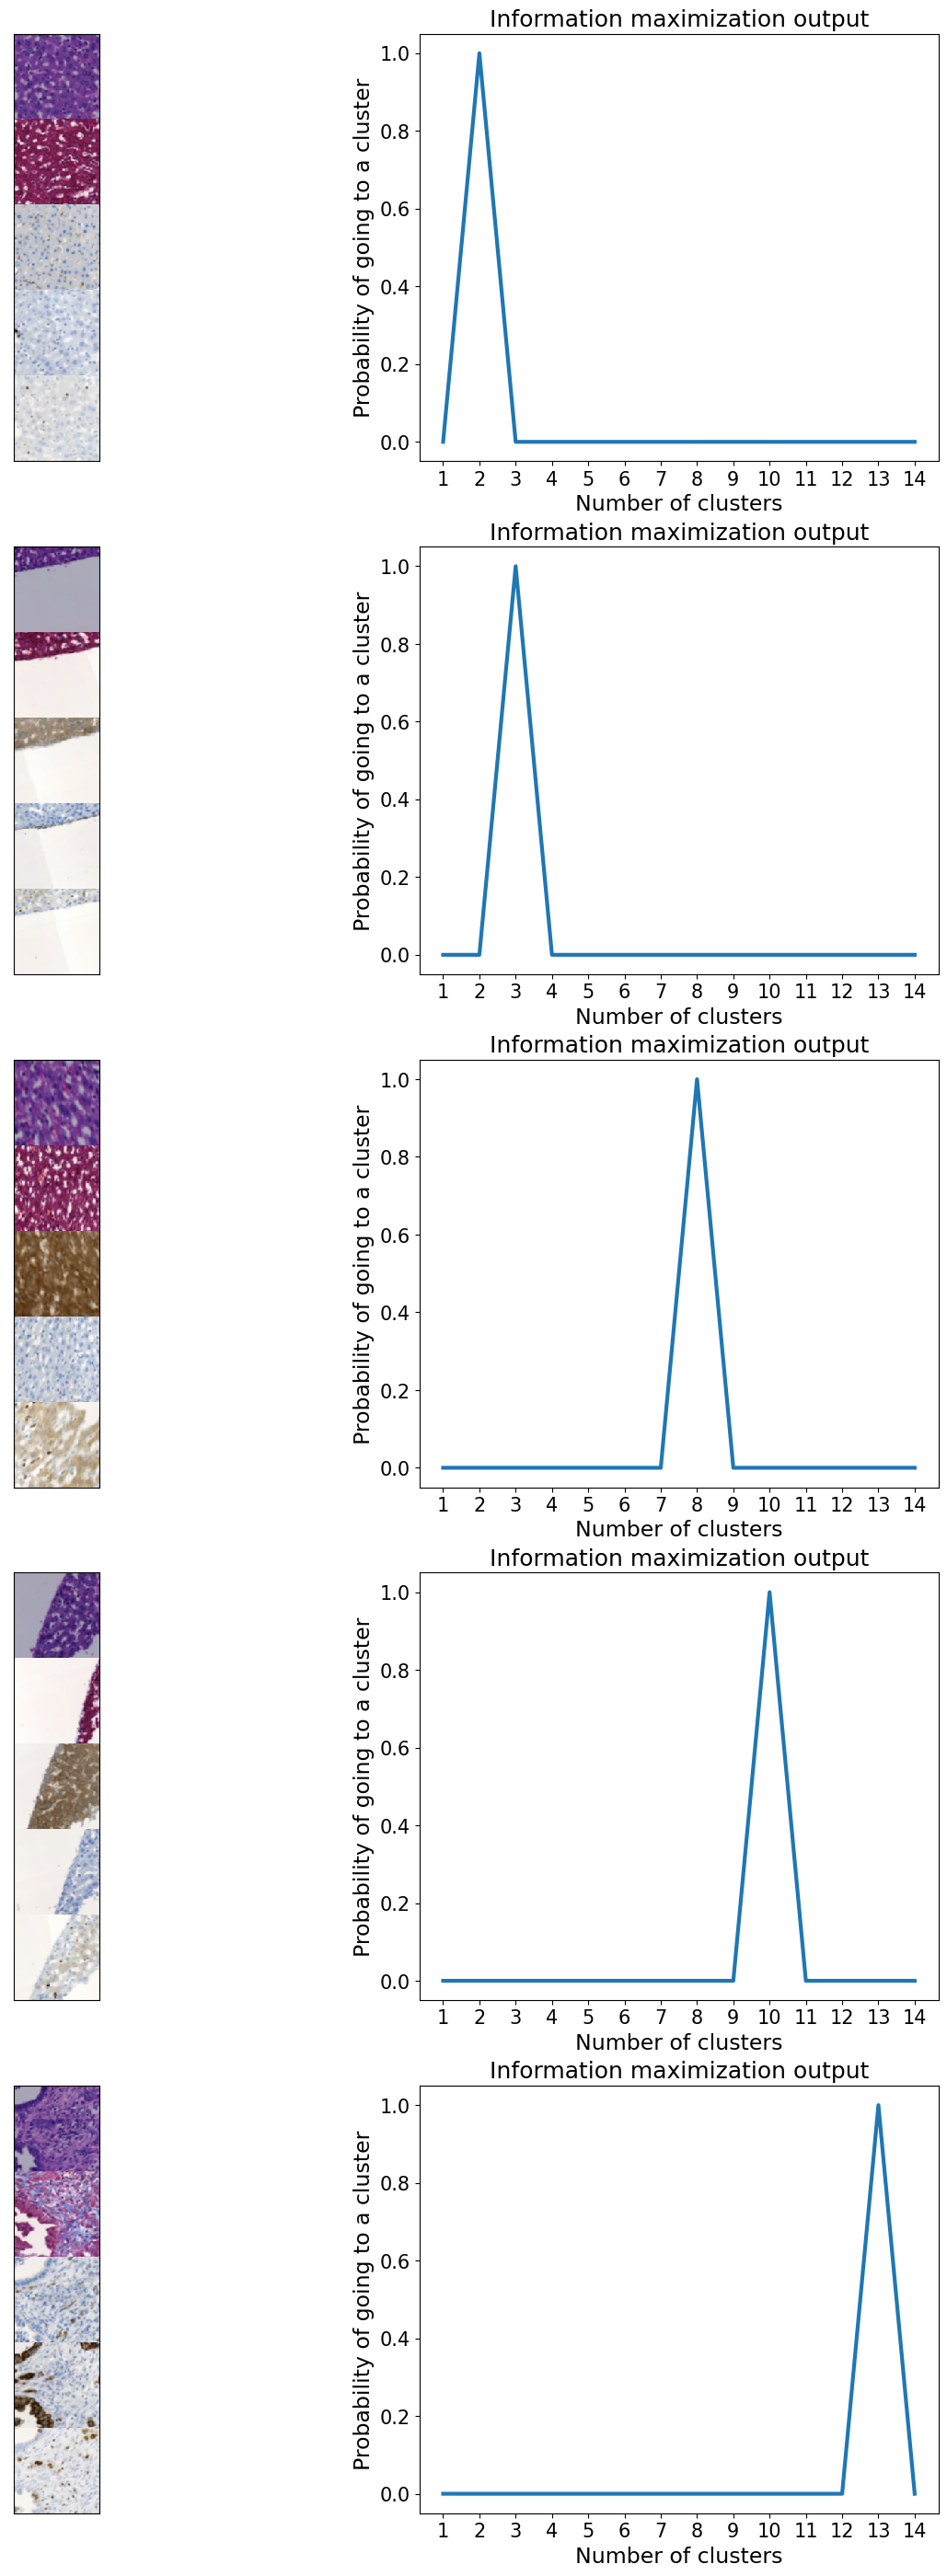

In [20]:
# plot IM output for selected unused samples

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(16, 35))

for i, j in zip(range(5), [c2_, c3_, c8_, c10_, c13_]):
    ax[i, 0].imshow(j, interpolation='nearest')
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    
for m, n in zip(range(5), range(len(IM_out))):
    ax[m, 1].plot(x, IM_out[n], linewidth=3)
    ax[m, 1].set_xticks(range(1, 15))
    ax[m, 1].tick_params(axis='x', labelsize=15)
    ax[m, 1].tick_params(axis='y', labelsize=15)
    ax[m, 1].set_xlabel('Number of clusters', fontsize=17)
    ax[m, 1].set_ylabel('Probability of going to a cluster', fontsize=17)
    ax[m, 1].set_title('Information maximization output', fontsize=18)